CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) for convolutional sparse coding with a spatial mask [[18]](http://sporco.rtfd.org/en/latest/zreferences.html#heide-2015-fast). The example problem is inpainting of randomly distributed corruption of a greyscale image.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
t = 0.5
np.random.seed(12345)
msk = np.random.randn(*(img.shape)).astype(np.float32)
msk[np.abs(msk) > t] = 1;
msk[np.abs(msk) < t] = 0;
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, pn, mode='symmetric')
zpad = lambda x:  np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[37]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional3)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

In [7]:
D = util.convdicts()['G:8x8x128']

Set up [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDNMaskDcpl.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 3e-2,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) object and solve.

In [9]:
b = cbpdn.ConvBPDNMaskDcpl(D, sh, lmbda, mskp, opt=opt)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  3.26e+01  3.68e-02  1.63e+03  1.34e-01  1.06e+00


   1  2.80e+01  2.06e-01  1.39e+03  1.18e-01  1.23e+00


   2  2.60e+01  3.43e-01  1.28e+03  1.10e-01  1.10e+00


   3  2.53e+01  4.17e-01  1.24e+03  1.05e-01  9.11e-01


   4  2.47e+01  4.66e-01  1.21e+03  1.01e-01  7.50e-01


   5  2.42e+01  5.07e-01  1.18e+03  9.47e-02  6.33e-01


   6  2.39e+01  5.47e-01  1.17e+03  8.94e-02  5.41e-01


   7  2.38e+01  5.87e-01  1.16e+03  8.50e-02  4.67e-01


   8  2.37e+01  6.29e-01  1.16e+03  8.11e-02  4.05e-01


   9  2.37e+01  6.69e-01  1.15e+03  7.76e-02  3.54e-01


  10  2.35e+01  7.06e-01  1.14e+03  7.44e-02  3.14e-01


  11  2.32e+01  7.39e-01  1.12e+03  7.15e-02  2.85e-01


  12  2.28e+01  7.68e-01  1.10e+03  6.88e-02  2.65e-01


  13  2.25e+01  7.94e-01  1.08e+03  6.65e-02  2.52e-01


  14  2.22e+01  8.16e-01  1.07e+03  6.44e-02  2.43e-01


  15  2.19e+01  8.37e-01  1.05e+03  6.25e-02  2.37e-01


  16  2.16e+01  8.57e-01  1.04e+03  6.07e-02  2.31e-01


  17  2.14e+01  8.77e-01  1.03e+03  5.90e-02  2.25e-01


  18  2.13e+01  8.98e-01  1.02e+03  5.75e-02  2.19e-01


  19  2.11e+01  9.18e-01  1.01e+03  5.60e-02  2.14e-01


  20  2.10e+01  9.39e-01  1.00e+03  5.46e-02  2.08e-01


  21  2.07e+01  9.61e-01  9.88e+02  5.32e-02  2.04e-01


  22  2.04e+01  9.83e-01  9.72e+02  5.18e-02  1.99e-01


  23  2.01e+01  1.01e+00  9.53e+02  5.04e-02  1.95e-01


  24  1.97e+01  1.03e+00  9.33e+02  4.90e-02  1.91e-01


  25  1.93e+01  1.05e+00  9.12e+02  4.76e-02  1.87e-01


  26  1.89e+01  1.07e+00  8.94e+02  4.64e-02  1.83e-01


  27  1.86e+01  1.09e+00  8.77e+02  4.52e-02  1.78e-01


  28  1.84e+01  1.11e+00  8.62e+02  4.40e-02  1.73e-01


  29  1.81e+01  1.13e+00  8.50e+02  4.30e-02  1.68e-01


  30  1.79e+01  1.14e+00  8.39e+02  4.20e-02  1.63e-01


  31  1.77e+01  1.16e+00  8.28e+02  4.10e-02  1.58e-01


  32  1.76e+01  1.18e+00  8.19e+02  4.01e-02  1.54e-01


  33  1.74e+01  1.19e+00  8.10e+02  3.92e-02  1.50e-01


  34  1.72e+01  1.20e+00  8.02e+02  3.84e-02  1.47e-01


  35  1.71e+01  1.21e+00  7.95e+02  3.76e-02  1.44e-01


  36  1.70e+01  1.23e+00  7.87e+02  3.68e-02  1.41e-01


  37  1.68e+01  1.24e+00  7.79e+02  3.61e-02  1.38e-01


  38  1.67e+01  1.25e+00  7.71e+02  3.54e-02  1.36e-01


  39  1.65e+01  1.26e+00  7.62e+02  3.48e-02  1.34e-01


  40  1.63e+01  1.26e+00  7.54e+02  3.41e-02  1.32e-01


  41  1.62e+01  1.27e+00  7.45e+02  3.35e-02  1.30e-01


  42  1.60e+01  1.28e+00  7.38e+02  3.29e-02  1.28e-01


  43  1.59e+01  1.29e+00  7.30e+02  3.23e-02  1.26e-01


  44  1.58e+01  1.30e+00  7.24e+02  3.18e-02  1.24e-01


  45  1.57e+01  1.31e+00  7.17e+02  3.12e-02  1.22e-01


  46  1.55e+01  1.31e+00  7.11e+02  3.07e-02  1.19e-01


  47  1.54e+01  1.32e+00  7.05e+02  3.02e-02  1.17e-01


  48  1.53e+01  1.33e+00  7.00e+02  2.97e-02  1.15e-01


  49  1.52e+01  1.33e+00  6.95e+02  2.92e-02  1.13e-01


  50  1.51e+01  1.34e+00  6.90e+02  2.87e-02  1.11e-01


  51  1.51e+01  1.34e+00  6.86e+02  2.83e-02  1.09e-01


  52  1.50e+01  1.35e+00  6.82e+02  2.78e-02  1.07e-01


  53  1.49e+01  1.35e+00  6.77e+02  2.74e-02  1.05e-01


  54  1.48e+01  1.36e+00  6.73e+02  2.70e-02  1.03e-01


  55  1.47e+01  1.36e+00  6.68e+02  2.65e-02  1.02e-01


  56  1.46e+01  1.36e+00  6.63e+02  2.61e-02  1.01e-01


  57  1.45e+01  1.37e+00  6.58e+02  2.57e-02  9.95e-02


  58  1.44e+01  1.37e+00  6.52e+02  2.53e-02  9.84e-02


  59  1.43e+01  1.37e+00  6.46e+02  2.50e-02  9.72e-02


  60  1.42e+01  1.37e+00  6.41e+02  2.46e-02  9.60e-02


  61  1.41e+01  1.38e+00  6.37e+02  2.43e-02  9.47e-02


  62  1.40e+01  1.38e+00  6.33e+02  2.39e-02  9.33e-02


  63  1.40e+01  1.38e+00  6.30e+02  2.36e-02  9.20e-02


  64  1.39e+01  1.39e+00  6.26e+02  2.33e-02  9.06e-02


  65  1.38e+01  1.39e+00  6.23e+02  2.30e-02  8.93e-02


  66  1.38e+01  1.39e+00  6.19e+02  2.27e-02  8.80e-02


  67  1.37e+01  1.40e+00  6.15e+02  2.24e-02  8.68e-02


  68  1.36e+01  1.40e+00  6.11e+02  2.21e-02  8.57e-02


  69  1.35e+01  1.40e+00  6.06e+02  2.18e-02  8.46e-02


  70  1.34e+01  1.41e+00  6.02e+02  2.16e-02  8.37e-02


  71  1.34e+01  1.41e+00  5.98e+02  2.13e-02  8.28e-02


  72  1.33e+01  1.41e+00  5.94e+02  2.10e-02  8.19e-02


  73  1.32e+01  1.42e+00  5.90e+02  2.07e-02  8.11e-02


  74  1.31e+01  1.42e+00  5.86e+02  2.05e-02  8.02e-02


  75  1.31e+01  1.42e+00  5.83e+02  2.02e-02  7.93e-02


  76  1.30e+01  1.43e+00  5.80e+02  2.00e-02  7.84e-02


  77  1.30e+01  1.43e+00  5.77e+02  1.97e-02  7.75e-02


  78  1.29e+01  1.43e+00  5.73e+02  1.95e-02  7.66e-02


  79  1.28e+01  1.43e+00  5.70e+02  1.93e-02  7.57e-02


  80  1.28e+01  1.44e+00  5.67e+02  1.90e-02  7.48e-02


  81  1.27e+01  1.44e+00  5.64e+02  1.88e-02  7.40e-02


  82  1.27e+01  1.44e+00  5.61e+02  1.86e-02  7.31e-02


  83  1.26e+01  1.44e+00  5.58e+02  1.84e-02  7.22e-02


  84  1.26e+01  1.45e+00  5.55e+02  1.82e-02  7.13e-02


  85  1.25e+01  1.45e+00  5.53e+02  1.80e-02  7.04e-02


  86  1.25e+01  1.45e+00  5.51e+02  1.78e-02  6.96e-02


  87  1.24e+01  1.45e+00  5.48e+02  1.75e-02  6.87e-02


  88  1.24e+01  1.45e+00  5.45e+02  1.73e-02  6.79e-02


  89  1.23e+01  1.46e+00  5.43e+02  1.71e-02  6.71e-02


  90  1.23e+01  1.46e+00  5.40e+02  1.70e-02  6.62e-02


  91  1.22e+01  1.46e+00  5.38e+02  1.68e-02  6.54e-02


  92  1.22e+01  1.46e+00  5.35e+02  1.66e-02  6.46e-02


  93  1.21e+01  1.46e+00  5.33e+02  1.64e-02  6.38e-02


  94  1.21e+01  1.46e+00  5.31e+02  1.62e-02  6.31e-02


  95  1.20e+01  1.47e+00  5.29e+02  1.61e-02  6.25e-02


  96  1.20e+01  1.47e+00  5.27e+02  1.59e-02  6.19e-02


  97  1.20e+01  1.47e+00  5.25e+02  1.57e-02  6.13e-02


  98  1.19e+01  1.47e+00  5.22e+02  1.56e-02  6.07e-02


  99  1.19e+01  1.47e+00  5.20e+02  1.54e-02  6.02e-02


 100  1.18e+01  1.47e+00  5.18e+02  1.52e-02  5.96e-02


 101  1.18e+01  1.48e+00  5.16e+02  1.51e-02  5.89e-02


 102  1.18e+01  1.48e+00  5.14e+02  1.49e-02  5.83e-02


 103  1.17e+01  1.48e+00  5.12e+02  1.48e-02  5.77e-02


 104  1.17e+01  1.48e+00  5.10e+02  1.46e-02  5.71e-02


 105  1.16e+01  1.48e+00  5.08e+02  1.45e-02  5.66e-02


 106  1.16e+01  1.48e+00  5.06e+02  1.43e-02  5.61e-02


 107  1.16e+01  1.48e+00  5.04e+02  1.42e-02  5.57e-02


 108  1.15e+01  1.49e+00  5.02e+02  1.40e-02  5.53e-02


 109  1.15e+01  1.49e+00  5.00e+02  1.39e-02  5.49e-02


 110  1.14e+01  1.49e+00  4.97e+02  1.37e-02  5.45e-02


 111  1.14e+01  1.49e+00  4.95e+02  1.36e-02  5.41e-02


 112  1.14e+01  1.49e+00  4.94e+02  1.35e-02  5.36e-02


 113  1.13e+01  1.49e+00  4.92e+02  1.33e-02  5.32e-02


 114  1.13e+01  1.49e+00  4.90e+02  1.32e-02  5.27e-02


 115  1.13e+01  1.49e+00  4.89e+02  1.31e-02  5.22e-02


 116  1.12e+01  1.49e+00  4.87e+02  1.30e-02  5.17e-02


 117  1.12e+01  1.49e+00  4.86e+02  1.28e-02  5.12e-02


 118  1.12e+01  1.50e+00  4.84e+02  1.27e-02  5.08e-02


 119  1.11e+01  1.50e+00  4.82e+02  1.26e-02  5.03e-02


 120  1.11e+01  1.50e+00  4.80e+02  1.25e-02  4.99e-02


 121  1.11e+01  1.50e+00  4.79e+02  1.24e-02  4.94e-02


 122  1.10e+01  1.50e+00  4.77e+02  1.22e-02  4.89e-02


 123  1.10e+01  1.50e+00  4.76e+02  1.21e-02  4.84e-02


 124  1.10e+01  1.50e+00  4.74e+02  1.20e-02  4.79e-02


 125  1.10e+01  1.50e+00  4.73e+02  1.19e-02  4.75e-02


 126  1.09e+01  1.50e+00  4.72e+02  1.18e-02  4.70e-02


 127  1.09e+01  1.50e+00  4.70e+02  1.17e-02  4.66e-02


 128  1.09e+01  1.50e+00  4.69e+02  1.16e-02  4.62e-02


 129  1.08e+01  1.51e+00  4.67e+02  1.15e-02  4.59e-02


 130  1.08e+01  1.51e+00  4.65e+02  1.14e-02  4.55e-02


 131  1.08e+01  1.51e+00  4.64e+02  1.13e-02  4.51e-02


 132  1.07e+01  1.51e+00  4.62e+02  1.12e-02  4.47e-02


 133  1.07e+01  1.51e+00  4.61e+02  1.11e-02  4.43e-02


 134  1.07e+01  1.51e+00  4.59e+02  1.10e-02  4.39e-02


 135  1.07e+01  1.51e+00  4.58e+02  1.09e-02  4.35e-02


 136  1.07e+01  1.51e+00  4.57e+02  1.08e-02  4.31e-02


 137  1.06e+01  1.51e+00  4.56e+02  1.07e-02  4.28e-02


 138  1.06e+01  1.51e+00  4.54e+02  1.06e-02  4.24e-02


 139  1.06e+01  1.51e+00  4.53e+02  1.05e-02  4.21e-02


 140  1.05e+01  1.51e+00  4.52e+02  1.04e-02  4.18e-02


 141  1.05e+01  1.52e+00  4.50e+02  1.03e-02  4.16e-02


 142  1.05e+01  1.52e+00  4.49e+02  1.02e-02  4.13e-02


 143  1.05e+01  1.52e+00  4.48e+02  1.02e-02  4.11e-02


 144  1.04e+01  1.52e+00  4.46e+02  1.01e-02  4.08e-02


 145  1.04e+01  1.52e+00  4.45e+02  1.00e-02  4.05e-02


 146  1.04e+01  1.52e+00  4.44e+02  9.92e-03  4.03e-02


 147  1.04e+01  1.52e+00  4.43e+02  9.83e-03  4.00e-02


 148  1.04e+01  1.52e+00  4.42e+02  9.75e-03  3.97e-02


 149  1.03e+01  1.52e+00  4.41e+02  9.67e-03  3.95e-02


 150  1.03e+01  1.52e+00  4.40e+02  9.59e-03  3.92e-02


 151  1.03e+01  1.52e+00  4.39e+02  9.52e-03  3.89e-02


 152  1.03e+01  1.52e+00  4.38e+02  9.44e-03  3.87e-02


 153  1.03e+01  1.52e+00  4.37e+02  9.36e-03  3.84e-02


 154  1.02e+01  1.52e+00  4.35e+02  9.29e-03  3.82e-02


 155  1.02e+01  1.53e+00  4.34e+02  9.21e-03  3.79e-02


 156  1.02e+01  1.53e+00  4.33e+02  9.14e-03  3.77e-02


 157  1.02e+01  1.53e+00  4.32e+02  9.06e-03  3.74e-02


 158  1.01e+01  1.53e+00  4.31e+02  8.99e-03  3.72e-02


 159  1.01e+01  1.53e+00  4.30e+02  8.93e-03  3.69e-02


 160  1.01e+01  1.53e+00  4.29e+02  8.86e-03  3.66e-02


 161  1.01e+01  1.53e+00  4.28e+02  8.79e-03  3.63e-02


 162  1.01e+01  1.53e+00  4.28e+02  8.73e-03  3.60e-02


 163  1.01e+01  1.53e+00  4.27e+02  8.67e-03  3.57e-02


 164  1.00e+01  1.53e+00  4.26e+02  8.60e-03  3.54e-02


 165  1.00e+01  1.53e+00  4.24e+02  8.54e-03  3.52e-02


 166  1.00e+01  1.53e+00  4.23e+02  8.47e-03  3.50e-02


 167  9.98e+00  1.53e+00  4.22e+02  8.40e-03  3.47e-02


 168  9.96e+00  1.53e+00  4.21e+02  8.34e-03  3.45e-02


 169  9.94e+00  1.53e+00  4.20e+02  8.28e-03  3.43e-02


 170  9.92e+00  1.53e+00  4.19e+02  8.22e-03  3.41e-02


 171  9.91e+00  1.53e+00  4.19e+02  8.16e-03  3.39e-02


 172  9.89e+00  1.53e+00  4.18e+02  8.10e-03  3.37e-02


 173  9.88e+00  1.53e+00  4.17e+02  8.05e-03  3.34e-02


 174  9.87e+00  1.53e+00  4.17e+02  7.99e-03  3.32e-02


 175  9.85e+00  1.53e+00  4.16e+02  7.93e-03  3.30e-02


 176  9.84e+00  1.53e+00  4.15e+02  7.88e-03  3.28e-02


 177  9.82e+00  1.53e+00  4.14e+02  7.82e-03  3.26e-02


 178  9.80e+00  1.54e+00  4.13e+02  7.76e-03  3.24e-02


 179  9.79e+00  1.54e+00  4.13e+02  7.70e-03  3.22e-02


 180  9.77e+00  1.54e+00  4.12e+02  7.65e-03  3.20e-02


 181  9.76e+00  1.54e+00  4.11e+02  7.59e-03  3.18e-02


 182  9.74e+00  1.54e+00  4.10e+02  7.54e-03  3.16e-02


 183  9.73e+00  1.54e+00  4.10e+02  7.49e-03  3.14e-02


 184  9.72e+00  1.54e+00  4.09e+02  7.44e-03  3.12e-02


 185  9.70e+00  1.54e+00  4.08e+02  7.38e-03  3.10e-02


 186  9.69e+00  1.54e+00  4.08e+02  7.33e-03  3.09e-02


 187  9.68e+00  1.54e+00  4.07e+02  7.28e-03  3.07e-02


 188  9.66e+00  1.54e+00  4.06e+02  7.23e-03  3.06e-02


 189  9.65e+00  1.54e+00  4.05e+02  7.18e-03  3.05e-02


 190  9.63e+00  1.54e+00  4.05e+02  7.14e-03  3.04e-02


 191  9.62e+00  1.54e+00  4.04e+02  7.09e-03  3.02e-02


 192  9.60e+00  1.54e+00  4.03e+02  7.04e-03  3.01e-02


 193  9.58e+00  1.54e+00  4.02e+02  7.00e-03  3.00e-02


 194  9.56e+00  1.54e+00  4.01e+02  6.95e-03  2.99e-02
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + b.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("ConvBPDNMaskDcpl solve time: %.2fs" % b.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

ConvBPDNMaskDcpl solve time: 272.44s
Corrupted image PSNR: 10.33 dB
Recovered image PSNR: 26.66 dB


Display reference, test, and reconstructed image

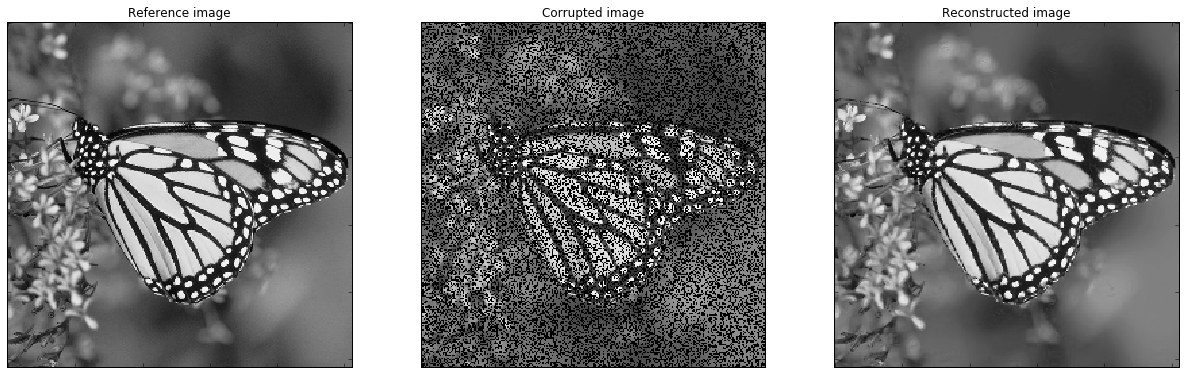

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, fig=fig, title='Reference image')
plot.subplot(1, 3, 2)
plot.imview(imgw, fig=fig, title='Corrupted image')
plot.subplot(1, 3, 3)
plot.imview(imgr, fig=fig, title='Reconstructed image')
fig.show()

Display lowpass component and sparse representation

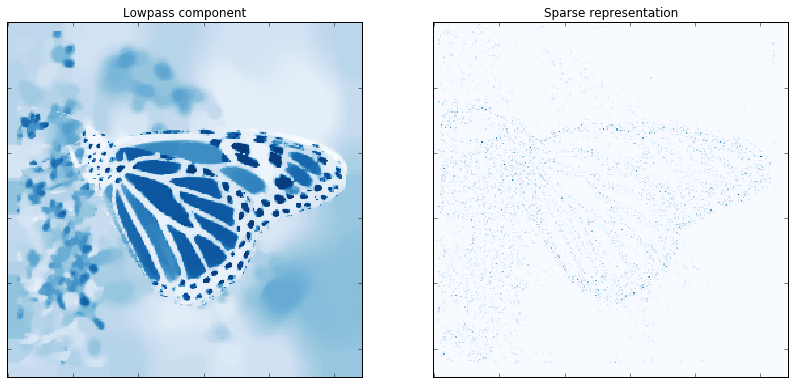

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, fig=fig, cmap=plot.cm.Blues, title='Lowpass component')
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=b.cri.axisM)), fig=fig,
            cmap=plot.cm.Blues, title='Sparse representation')
fig.show()

Plot functional value, residuals, and rho

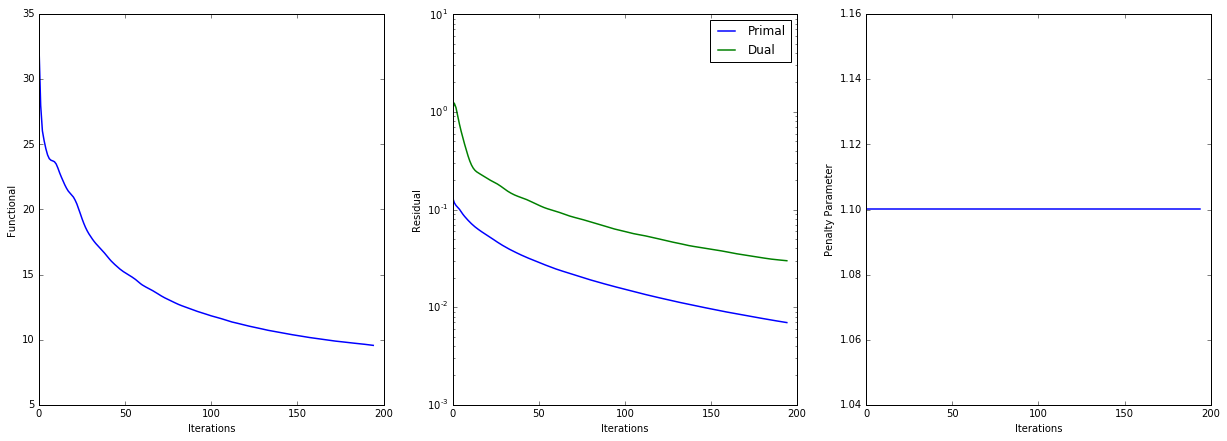

In [14]:
its = b.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, fig=fig, xlbl='Iterations', ylbl='Functional')
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, fig=fig,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.subplot(1, 3, 3)
plot.plot(its.Rho, fig=fig, xlbl='Iterations', ylbl='Penalty Parameter')
fig.show()